<a href="https://colab.research.google.com/github/harujem/dataAnalysis/blob/main/2_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D_05_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%88%98%EC%A7%91_OpenAPI_%EC%99%84%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 분석

## 5. OpenAPI를 이용한 데이터 수집

- <a href="#1)OpenAPI통한데이터수집">1) OpenAPI 통한 데이터 수집</a>
- <a href="#2)한글텍스트Cleansing">2) 한글 텍스트 Cleansing</a>
- <a href="#3)웹이미지수집하기">3) 웹 이미지 수집하기</a>

### #그래프에서 한글사용하는 방법
- **(코랩에서)한글폰트 설치하기**

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 코랩에서 위 코드를 실행시킨 후  반드시 코랩 메뉴: "런타임>런타임 다시 시작" 합니다.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,676 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and dire

- **한글 폰트 지정하기**

In [1]:
# 코랩에서 한글 폰트 종류와 이름이 win과 다를 수 있다!!!
# 코랩: NanumGothic, 윈도우: Malgun Gothic
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'NanumGothic',
                     'font.size': 12,
                     'figure.figsize': (6, 4),
                     'axes.unicode_minus':  False }) # 폰트 설정

---

### <a name="1)OpenAPI통한데이터수집">1) OpenAPI 통한 데이터 수집</a>

#### 1.네이버 OpenAPI 신청하기
* 네이버 검색(책, 뉴스, 쇼핑)
    - 네이버 OpenAPI 소개: https://developers.naver.com/products/intro/plan/
    - 개발 가이드 보기: https://developers.naver.com/docs/serviceapi/search/news
    - OpenAPI 신청하기: https://developers.naver.com/apps/#/register

#### 2.네이버 OpenAPI 사용하기
* 검색
    - 1.책 검색
    - 2.뉴스 검색
    - 3.쇼핑 검색

#### [실습] : 네이버 검색 API 사용하여 데이터 수집하기

In [ ]:
# 정적 크롤링을 위한 requests 설치
!pip install requests

In [19]:
import os
import sys
import urllib.request
import datetime
import time
import json
import pandas as pd

now = datetime.datetime.now()
datas = []   #csv파일을 위한 변수

#네이버 애플리케이션
client_id = '88ojQ73w1pUAtojxHKbD'          # 자신의 client_id
client_pw = 'YLiXb9GLFh'                    # 자신의 client_secret
PATH = './'         # 수집 데이터 저장 폴더


#[CODE 1]
def get_RequestUrl(url):
    req = urllib.request.Request(url)
    req.add_header("X-Naver-Client-Id", client_id)
    req.add_header("X-Naver-Client-Secret", client_pw)

    try:
        response = urllib.request.urlopen(req)
        if response.getcode() == 200:
            print(f"[{now.strftime('%Y년%m월%d일 %H시%M분%S초')}] Url Request Success")
            return response.read().decode('utf-8')

    except Exception as e:
#         if response.getcode() == 400 and datas:
#             return None
        print(e)
        print(f"[{now.strftime('%Y년%m월%d일 %H시%M분%S초')}] Error for URL : {url}" )
        return None


#[CODE 2]  네이버 검색 API
def get_NaverSearch(node, keyword, start, display):
    base = "https://openapi.naver.com/v1/search"
    node = "/%s.json" % node
    parameters = "?query=%s&start=%s&display=%s" % (urllib.parse.quote(keyword), start, display)

    url = base + node + parameters
    responseDecode = get_RequestUrl(url)   #[CODE 1]

    if (responseDecode == None):
        return None
    else:
        return json.loads(responseDecode)

#[CODE 3]
def get_PostData(node, post, jsonResult, cnt):
    if node == 'book':
        data = {'제목':post['title'],
                '저자':post['author'],
                '출판사':post['publisher'],
                '출간일':post['pubdate'],
                '링크':post['link'],
                '이미지':post['image']}
    elif node == 'news':
        data = {'제목':post['title'],
                '링크':post['originallink'],
                '내용':post['description']}
    elif node == 'shop':
        data = {'제목':post['title'],
                '브랜드':post['brand'],
                '제조사':post['maker'],
                '가격':post['lprice'],
                '이미지':post['image']}

    jsonResult.append(data)
    datas.append(data)

    return

#[CODE 0]
def main():
    global node, keyword

    nodeType = '''-----------------------------
    네이버 검색 대상입니다.
      1.book,  2.news,  3.shop
    -----------------------------'''
    print(nodeType)
    node = input('번호를 선택하세요.[1:책, 2:뉴스, 3:쇼핑]')
    if node == '1': node = 'book'
    elif node == '2': node = 'news'
    elif node == '3': node = 'shop'
    else:
        node == '1'
        node = 'book'

    keyword = input(f'{node} 검색할 검색어를 입력하세요: ')

    display, cnt = 100, 0
    jsonResult = []
    jsonResponse = get_NaverSearch(node, keyword, 1, display)  #[CODE 2]
    total = jsonResponse['total']

    while ((jsonResponse != None) and (jsonResponse['display'] != 0)):
        for post in jsonResponse['items']:
            cnt += 1
            get_PostData(node, post, jsonResult, cnt)  #[CODE 3]

        start = jsonResponse['start'] + jsonResponse['display']
        jsonResponse = get_NaverSearch(node, keyword, start, total)
#     print(f'가져올 데이터 : {total} 건')

    # with open(f'{PATH}/naver_{node}_{keyword}', 'w', encoding='utf8') as outfile:
    #     jsonFile = json.dumps(jsonResult,  indent=4, sort_keys=True,  ensure_ascii=False)

    #     outfile.write(jsonFile)

    print("가져온 데이터 : %d 건" %(cnt))



    # csv 파일로 저장하기 (검색어에 공백이 있는 경우 빠져있음)
    file = f'{PATH}/naver_{node}_{keyword}.csv'
    df = pd.DataFrame(datas)
    df.to_csv(file, index=False, encoding="utf-8-sig")
    print(f'{PATH}/naver_{node}_{keyword}.csv SAVED')
    return df

#-----------
# 시작
#-----------
df = main()
df.head()

-----------------------------
    네이버 검색 대상입니다.
      1.book,  2.news,  3.shop
    -----------------------------
번호를 선택하세요.[1:책, 2:뉴스, 3:쇼핑]2
news 검색할 검색어를 입력하세요: 지구온난화
[2024년04월25일 03시31분31초] Url Request Success
HTTP Error 400: Bad Request
[2024년04월25일 03시31분31초] Error for URL : https://openapi.naver.com/v1/search/news.json?query=%EC%A7%80%EA%B5%AC%EC%98%A8%EB%82%9C%ED%99%94&start=101&display=220850
가져온 데이터 : 100 건
.//naver_news_지구온난화.csv SAVED


,제목,링크,내용
0,【Trend Insight】엑손모빌은 왜 유엔 플라스틱협상에서 목소리를 높이고 있을...,http://www.impacton.net/news/articleView.html?...,올해 말 합의될 예정인 이 협약은 2015년 197개 당사국이 합의한 '파리협약' ...
1,"진천종박물관, 가정의달 문화행사 ‘<b>지구</b>를 지켜라’ 운영",https://www.joongdo.co.kr/web/view.php?key=202...,온실가스와 이산화탄소 배출에 따른 <b>지구온난화</b> 문제를 어린이의 눈높이에 ...
2,"진천종박물관, 가정의달 문화행사 운영",http://www.jbnews.com/news/articleView.html?id...,온실가스와 이산화탄소 배출에 따른 <b>지구온난화</b> 문제를 어린이 눈높이에 맞...
3,기후위기-민생 걱정이시죠? '군사비 감축'이 도움 될 것입니다,https://www.ohmynews.com/NWS_Web/View/at_pg.as...,유엔 안토니오 구테흐스 사무총장은 &quot;<b>지구 온난화</b>(global ...
4,더벤티도 최대 500원 올려…컴포즈 등 저가커피 인상 이어질까,https://www.newsis.com/view/?id=NISX20240425_0...,"원두 가격 인상은 <b>지구 온난화</b>, 이상기후에 따른 작황 부진이 원인이다...."




---



#### (24.2.29 서비스 종료됨)[실습] :  네이버 Papago API 사용하여 번역하기

In [ ]:
# import os
# import sys
# import urllib.request
# import datetime
# import json


# client_id = ''  # 자신의 파파고 NMT API ID
# client_pw = ''            # 자신의 파파고 NMT API PASSWORD

# news = []   #csv파일을 위한 변수

# #[CODE 1]
# def papago(prompt, lang=1):

#     encText = urllib.parse.quote(prompt)
#     if lang == 1 :
#         data = "source=ko&target=en&text=" + encText
#     else:
#         data = "source=en&target=ko&text=" + encText
#     url = "https://openapi.naver.com/v1/papago/n2mt"

#     req = urllib.request.Request(url)
#     req.add_header("X-Naver-Client-Id", client_id)
#     req.add_header("X-Naver-Client-Secret", client_pw)

#     try:
#         response = urllib.request.urlopen(req, data=data.encode("utf-8") )
#         if response.getcode() == 200:
#             print(f"[{now.strftime('%Y년%m월%d일 %H시%M분%S초')}] Url Request Success")
#             responseDecode = response.read().decode('utf-8')

#             if responseDecode == None:
#                 return None
#             else:
#                 return json.loads(responseDecode)

#     except Exception as e:
#         print(e)
#         print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
#         return None

# # 메인
# lang= int(input('[선택] 1:한글->영어, 2:영어->한글: '))
# txt =  '한글' if lang==1 else '영어'
# prompt= input(f'[번역] 변환할 문장을 입력하세요.[{txt}로 입력]: ')

# jsonResponse = papago(prompt, lang)  # 파파고 번역
# jsonResponse
# print('-'*50)
# print(f"[번역 결과] => {jsonResponse['message']['result']['translatedText']}")


-------------------------

### <a name="2)한글텍스트Cleansing">2) 한글 텍스트 Cleansing</a>

#### 1.라이브러리 설치

In [10]:
# 자연어처리 형태소 분석 및 토큰화
!pip install nltk

In [11]:
# (한글)자연어처리 형태소 분석 및 토큰화
# (WinOS에서는 konlpy를 사용하기 위해 JDK를 설치해야 오류가 없어 코랩에서 실행함)
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 31.5 MB/s eta 0:00:00


In [12]:
# html tag parsing을 위한 라이브러리
!pip install beautifulsoup4

In [13]:
# 사이킷런 CountVectorizer클래스 사용 : 단어 빈도수 추출
!pip install scikit-learn

#### 2.한글 테스트 자연어 처리(Text Cleansing)
- 앞에서 OpenAPI를 사용하여 뉴스 데이터를 가져온 뒤에 아래 코트를 실행시키도록 한다.


In [ ]:
# 클렌징할 파일을 가져와서 텍스트 사이에 지저분하게 들어있는 태그 등을 제거해준다.
# import re 정규표현 레귤러 라이브러리

In [20]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import konlpy
import nltk

def clean_korean_documents(documents):
    #텍스트 정제 (HTML 태그 제거)
    for i, document in enumerate(documents):
        document = BeautifulSoup(document, 'html.parser').text #텍스트만 받음
        documents[i] = document

    #텍스트 정제 (특수기호 제거)
    for i, document in enumerate(documents):
        document = re.sub(r'[^ ㄱ-ㅣ가-힣]', '', document) #특수기호 제거, 정규 표현식
        documents[i] = document

    #텍스트 정제 (형태소 분석)
    for i, document in enumerate(documents):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True): #어간 추출
            if word[1] in ['Noun', 'Verb', 'Adjective']: #명사, 동사, 형용사
                clean_words.append(word[0])
        document = ' '.join(clean_words)
        documents[i] = document

    #텍스트 정제 (불용어 제거)
    df = pd.read_csv('https://raw.githubusercontent.com/cranberryai/todak_todak_python/master/machine_learning_text/clean_korean_documents/korean_stopwords.txt', header=None)
    df[0] = df[0].apply(lambda x: x.strip())
    stopwords = df[0].to_numpy()
    nltk.download('punkt')
    for i, document in enumerate(documents):
        clean_words = []
        for word in nltk.tokenize.word_tokenize(document):
            if word not in stopwords: #불용어 제거
                clean_words.append(word)
        documents[i] = ' '.join(clean_words)

    return documents


def clean_target_feature(data):
    x_data = data.to_list()
    return clean_korean_documents(x_data)



# ---------------------
# 1.클린징할 파일 가져오기
file = f'{PATH}/naver_{node}_{keyword}.csv'  # 앞에서 만들어진 파일 사용하기
file = 'naver_news_지구온난화.csv'
df = pd.read_csv(file)

# 2.클린징할 컬럼 선택해서 클린징하기
# (앞 OpenAPI검색에서 2.news 검색을 한 후 실행하기)
# df['제목'] = clean_korean_documents(df['제목'].to_list())
df['제목'] = clean_target_feature(df['제목'])  # 기사 제목
df['내용'] = clean_target_feature(df['내용'])  # 기사 내용

# 3.클린징 결과 csv 파일로 저장하기
file = f'{PATH}/naver_{node}_{keyword}_clean.csv'
df.to_csv(file, index=False, encoding="utf-8-sig")
print(f'{file} SAVED')

df.head()


<ipython-input-20-60000163ba87>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  document = BeautifulSoup(document, 'html.parser').text #텍스트만 받음
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


.//naver_news_지구온난화_clean.csv SAVED


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,제목,링크,내용
0,엑손모빌 왜 유엔 플라스틱 협상 목소리 높이 있다,http://www.impacton.net/news/articleView.html?...,올해 합의 되다 예정 협약 사국 합의 파리 협약 이후 지구온난화 막다 위 가장 중요...
1,진천 종 박물관 가정 달 문화 행사 지구 지키다 운영,https://www.joongdo.co.kr/web/view.php?key=202...,온실가스 이산화탄소 배출 따르다 지구온난화 어린이 눈높이 맞다 설명 흥미롭다 이해 ...
2,진천 종 박물관 가정 달 문화 행사 운영,http://www.jbnews.com/news/articleView.html?id...,온실가스 이산화탄소 배출 따르다 지구온난화 어린이 눈높이 맞다 설명 흥미롭다 이해 ...
3,기후 위기 민생 걱정 시 군사 비 감축 도움 되다 이다,https://www.ohmynews.com/NWS_Web/View/at_pg.as...,유엔 안토니오 구테흐스 사무 총장 지구 온난화 시대 끝나다 지구 끓다 시대 시작 돼...
4,베다 티 최대 올리다 컴 포즈 저가 커피 인상 이어지다,https://www.newsis.com/view/?id=NISX20240425_0...,원두 가격 인상 지구 온난화 이상기후 따르다 작황 부진 원인 지난해 원유 가격 오르...


#### 3.워드 클라우드 만들기

In [23]:
!pip install wordcloud

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

# 말뭉치를 토큰화하여 빈도수 가져오기
def get_wordTokenCount(corpus):
    from sklearn.feature_extraction.text import CountVectorizer

    # 말뭉치를 토큰화하기
    vect = CountVectorizer().fit(corpus)
    count = vect.transform(corpus).toarray().sum(axis=0)

    # 토큰 빈도수로 정렬하고 토큰명 추출
    idx = np.argsort(-count)  # 내림 정렬하여 인덱스 반환: 토큰의 인덱스
    count = count[idx]        # 토큰의 빈도수
    feature_name = np.array(vect.get_feature_names_out())[idx]  # 토큰값

    # 빈도수 많은 순서대로 토큰명 10개만 출력
    print(list(zip(feature_name, count))[:10])

    return feature_name, count


# 단어(토큰) 빈도수 막대 그래프 그리기
def draw_wordTokenCountGraph(data, freq):
    plt.bar(data, freq)
    plt.grid()
    plt.show()

    # 그래프 그림 저장히기
    plt.savefig(f'./token_bar_graph.png')

# 워드클라우드 만들기
def make_wordcloud(feature_name, count):
    # 한글 폰트 경로를 설정
    font_path = 'NanumGothic'  #/usr/share/fonts/truetype/nanum/NanumGothic.ttf  #코랩
    # font_path = 'malgun'  # C:/Windows/Fonts/                                  #window

    # (토큰명, 빈도수) 딕셔너리 타입으로 변환
    data = dict(zip(feature_name, count))

    # 워드클라우드로 그래프로 시각화
    wc = WordCloud(width = 1000, height = 600, background_color="black", font_path=font_path)
    plt.imshow(wc.generate_from_frequencies(data)) #딕셔너리
    plt.axis("off")
    plt.show()

    # 이미지 파일로 저장하기
    wc.to_file(f'./워드클라우드.png')


[('지구', 17), ('하다', 12), ('탄소', 10), ('중립', 9), ('기후', 9), ('허창', 7), ('훈장', 7), ('위기', 7), ('수훈', 6), ('환경', 6)]


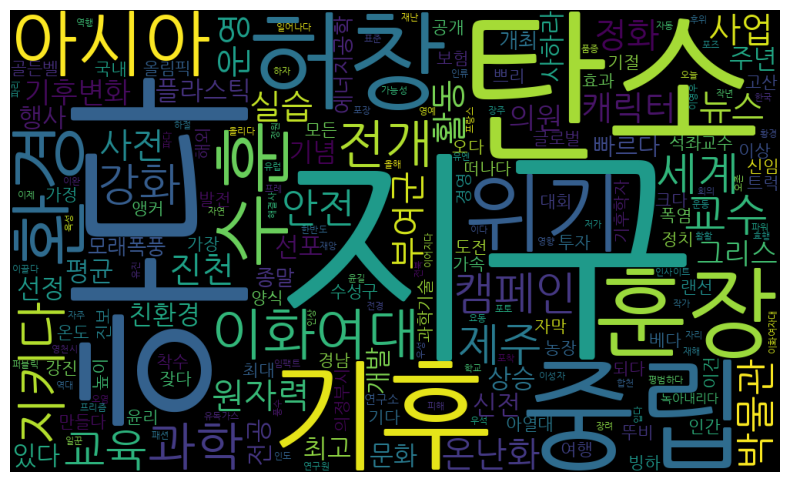

In [27]:
import pandas as pd

# 1.텍스트 말뭉치(corpus) 데이터 지정하기
corpus = df['제목'].to_list()
# print(corpus)

# 2.말뭉치를 토큰화하여 빈도수 가져오기
feature_name, count = get_wordTokenCount(corpus)

# 3.단어(토큰) 빈도수 막대 그래프 그리기(상위 10개)
# draw_wordTokenCountGraph(feature_name[:10], count[:10])

# 3.워드 클라우드 만들기
make_wordcloud(feature_name, count)



---



### <a name="3)웹이미지수집하기">3) 웹 이미지 수집하기</a>

#### 1.웹 이미지 화면에 출력하기

In [34]:
from IPython.display import Image
Image(url='https://shopping-phinf.pstatic.net/main_8658737/86587372902.jpg')

#### 2.웹 이미지 파일로 저장하기

In [31]:
import requests
from io import BytesIO
from PIL import Image

# 다운받을 이미지 url
urls = [
    "https://shopping-phinf.pstatic.net/main_3815224/38152244716.20230516165404.jpg",
    "https://shopping-phinf.pstatic.net/main_3726611/37266116619.20230119071117.jpg"
]
# 파일로 저장하기
for idx, url in enumerate(urls):
    res = requests.get(url)                   # url 요청
    print(res)
    img = Image.open(BytesIO(res.content))    # 응답결과(res.content)바이트파일 이미지 파일로 오픈
    img.save(f'./testimg_{idx}.png', 'png')   # 'png'이미지로(만) 저장

<Response [200]>
<Response [200]>


#### [실습] : 웹 이미지 수집하기
- 앞에서 저장한 쇼핑 목록에 있는 URL을 이용하여 이미지 저장하기

In [33]:
# 이미지 다운로드 하기
import pandas as pd
import requests
from io import BytesIO
from PIL import Image
import time
import os

# 자신에게 맞게 폴더/파일 위치 정보를 수정한다.
FILE = f'./naver_shop_샤넬백.csv'  # 앞에서 자신이 검색한 쇼핑 파일
ImgFolder = f'./download/'       # 다운받을 이미지 폴더
MAX = 10                         # 이미지 파일 다운로드 건수

def getImageUrl(file):
    print(f'읽은 파일명: {file}')
    df = pd.read_csv(file, encoding='utf-8') # 이미지가 있는 쇼핑 파일 불러오기
    return df['이미지'].to_list()

def createDirectory(directory): # 다운받을 이미지 폴더 만들기
    try:
        if not os.path.exists(directory):
            print(f'{directory} 폴더가 생성되었습니다.')
            os.makedirs(directory)
        print(f'이미지 폴더 위치 : {directory}')
    except OSError:
        print("Error: Failed to create the directory.")

def downloadImageFile(urls, imgfolder):
    start = time.time()             # 이미지 다운로드 속도 time check
    for idx, url in enumerate(urls):
        if idx == MAX:
            break  # MAX 건수만 처리하기
        res = requests.get(url)     # request.get 요청
#         print(f'[{idx+1:2>}][{time.time() - start}] : {url}')  # 이미지 다운로드 시간 체크
        print(f'[{idx+1:0>2}] : {url}')  # 이미지 다운로드 시간 체크
        img = Image.open(BytesIO(res.content))  #Img open
        img.save(f'{imgfolder}testimage_{idx}.png', 'png')
    return idx


urls = getImageUrl(FILE)                # 이미지 URL 목록 가져오기
createDirectory(ImgFolder)              # 다운받을 이미지 폴더 만들기
totalcnt = downloadImageFile(urls, ImgFolder)      # 이미지 다운로드하기
print(f'총 다운로드 건수: {totalcnt}')


읽은 파일명: ./naver_shop_샤넬백.csv
이미지 폴더 위치 : ./download/
[01] : https://shopping-phinf.pstatic.net/main_8669154/86691545484.jpg
[02] : https://shopping-phinf.pstatic.net/main_8573410/85734102629.11.jpg
[03] : https://shopping-phinf.pstatic.net/main_8284121/82841219006.20.jpg
[04] : https://shopping-phinf.pstatic.net/main_8523594/85235940000.2.jpg
[05] : https://shopping-phinf.pstatic.net/main_8321991/83219914550.jpg
[06] : https://shopping-phinf.pstatic.net/main_8668965/86689658818.jpg
[07] : https://shopping-phinf.pstatic.net/main_8448659/84486597620.jpg
[08] : https://shopping-phinf.pstatic.net/main_8269922/82699228782.jpg
[09] : https://shopping-phinf.pstatic.net/main_8658737/86587372902.jpg
[10] : https://shopping-phinf.pstatic.net/main_8648847/86488479864.jpg
총 다운로드 건수: 10


---------------------------

끝!